## Introduction

**In a previous project, I used that data and after processing it I applied machine learning algorithms to it, but the results were not to the required degree and the results are over-processed, so I will modify the strategy I am working on and use a more powerful and appropriate method, according to what I get from my search, But I have another return to this project to amend it. Because this project is nothing but a simple experiment.**

**I go further....**

**The goal of this kernel is to use a combination of several different models to classify whether a sample is safe or not.**

Glossary:

```
1. EDA and Preprocessing  
    1.1. Load Data
    1.2. Format Feature Names
    1.3. Dealing with missing data
    1.4. Feature Analysis
    1.5. Feature Correlation
    1.6. Decision Tree as EDA

2. Data Transformation Pipeline
    2.1. Create a Holdout Set
    2.2. Creating the Pipeline

3. Model Creation
    3.1. Creating Estimator Pipelines
    3.2. Initial Model Scoring

4. Ensembling
    4.1. Learning Curves
    4.2. Ensemble Creation and Final Testing
```

## Calling the necessary software libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

## Part 1: EDA and Preprocessing

## 1.1. Load Data

In [ ]:
mssing_values=['#NUM!' , np.nan , 'NaN', 'ckd\t']
data=pd.read_csv('/content/waterQuality1.csv', na_values=mssing_values)
warnings.filterwarnings('ignore')

## 1.2: Format Feature Names

In [ ]:
data.columns=[x.strip() for x in data.columns]
data=data.apply(lambda x: x.str.strip() if x.dtype=='object' else x)
#data.head()

# 1.3: Dealing with missing data

In [ ]:
data.isnull().sum().any()

True

In [ ]:
data = data.dropna()
data.isnull().sum().any()

False

## 1.4: Feature Analysis

In [ ]:
#data.describe()

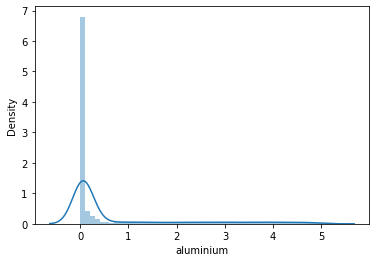

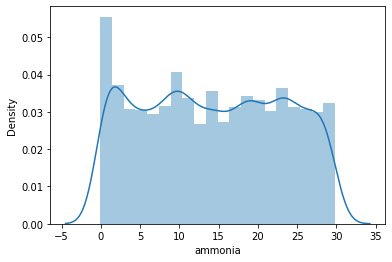

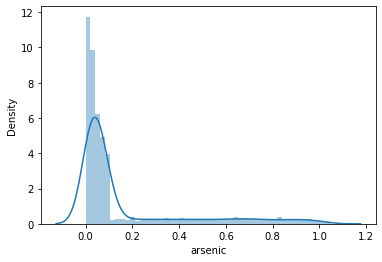

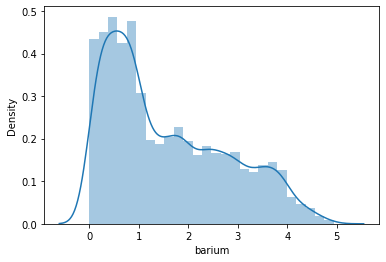

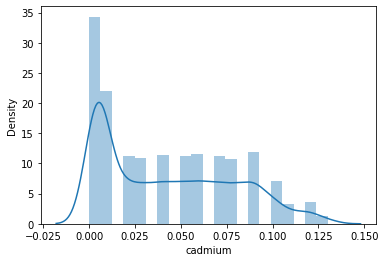

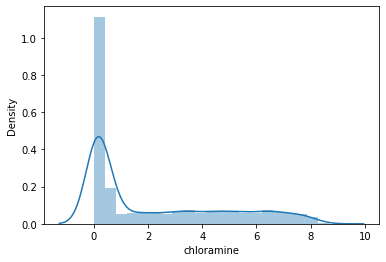

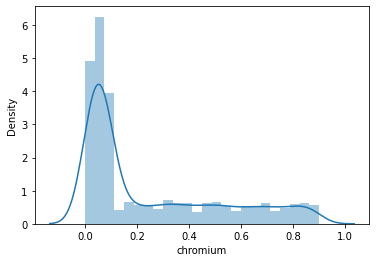

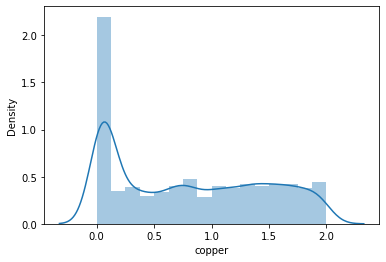

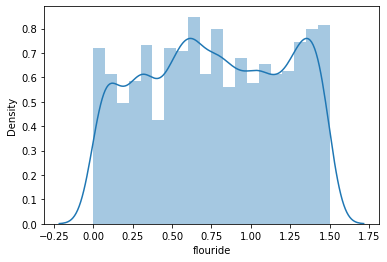

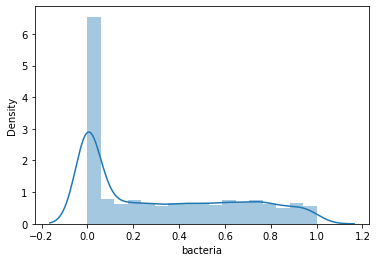

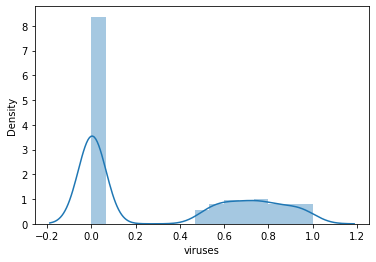

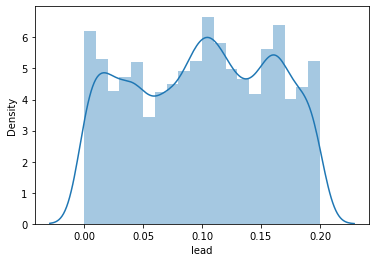

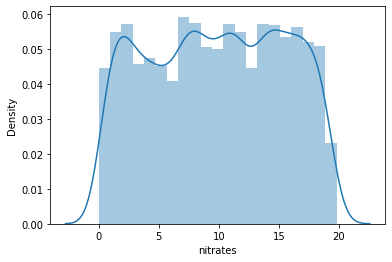

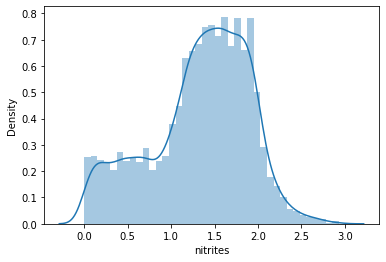

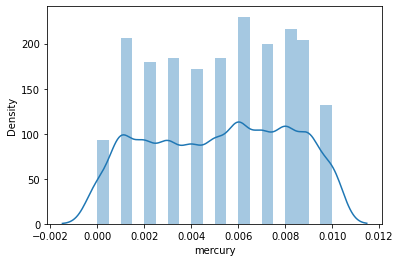

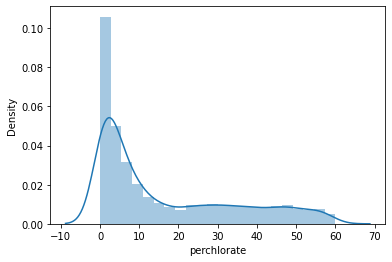

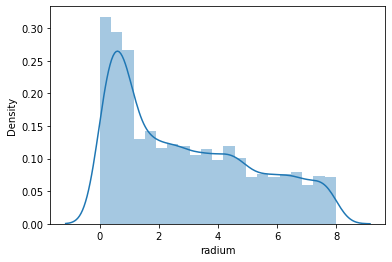

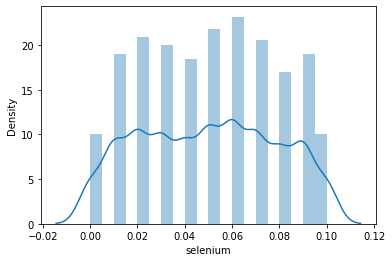

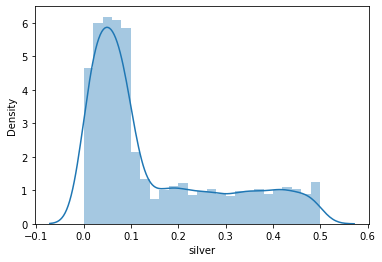

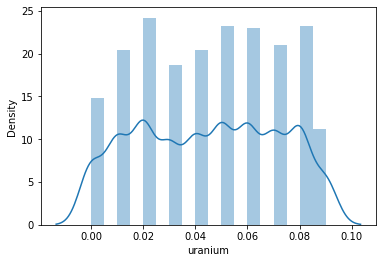

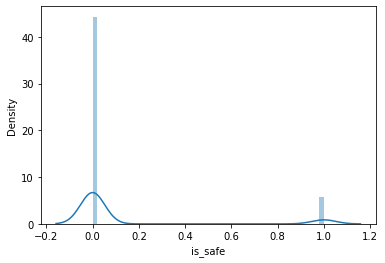

In [ ]:
for i, col in enumerate(data.columns):
    plt.figure(i)   
    plot=sns.distplot(data[col])
    plot

In [ ]:
target=data['is_safe']
data=data.drop(columns=['is_safe'])

## 1.5: Feature Correlation

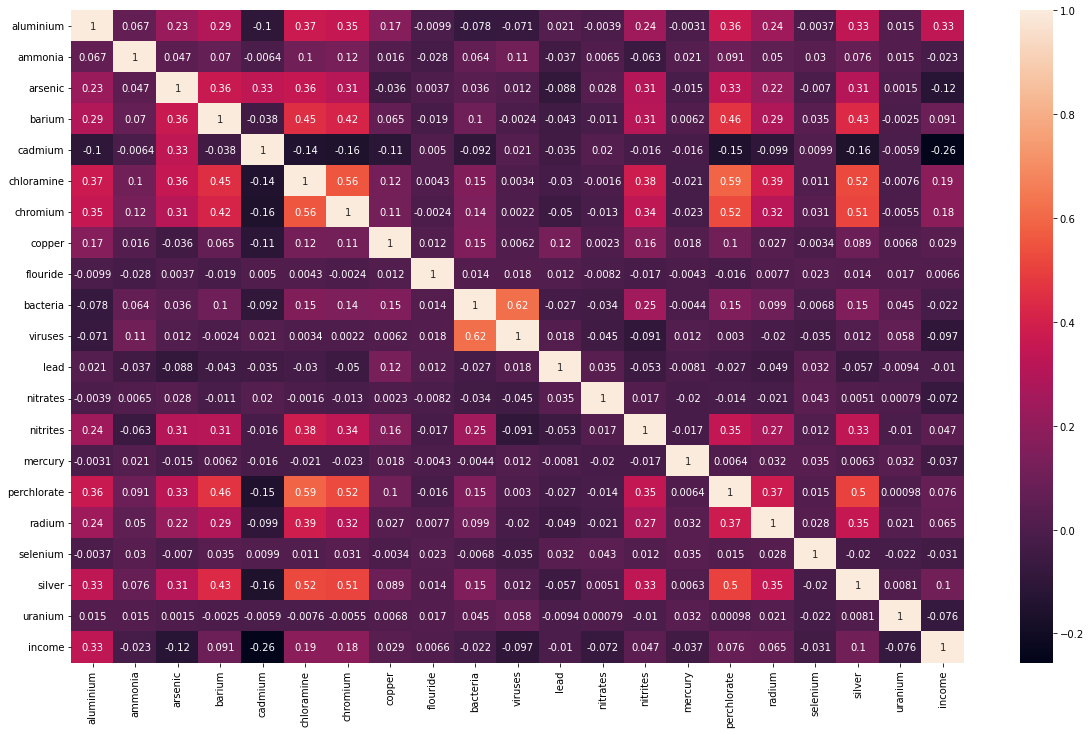

In [ ]:
plt.figure(figsize=(20,12))
sns.heatmap(data.assign(income=target).corr(),annot=True)

## 1.6: Decision Tree as EDA

**Since I will be using tree-based methods as an aside from our set, I want to see how the underlying decision tree will interact with our data set. I'll start by creating a single encoded dataset to fit into the decision tree classifier.**

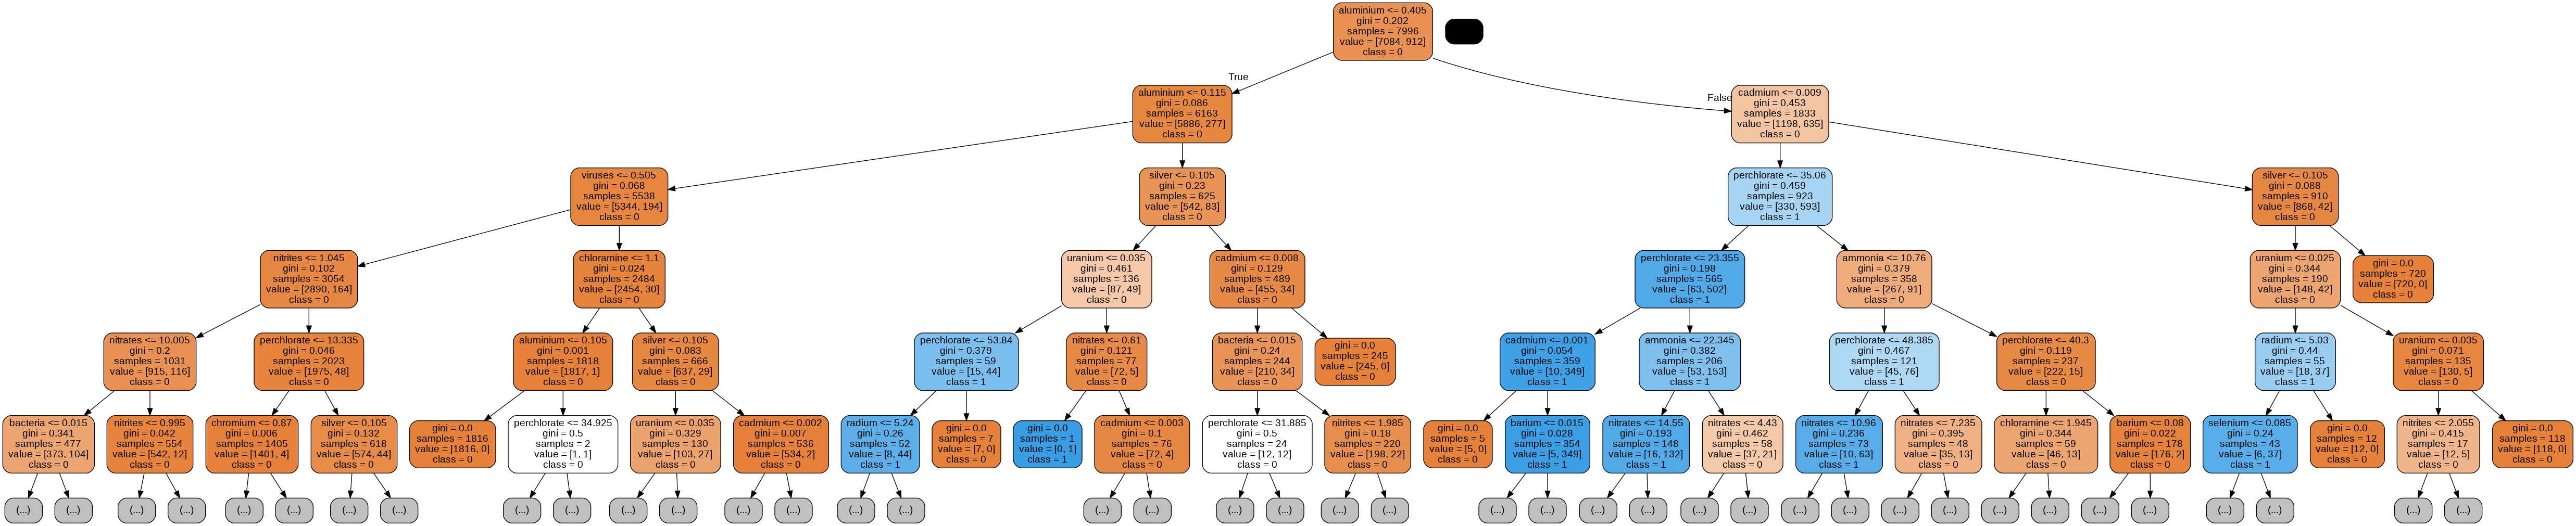

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import pydot

#data_oh=data_oh.drop(columns=['fnlwgt'])
tree=DecisionTreeClassifier().fit(data,target)

with open("tree1.dot", 'w') as dot:
    dot = export_graphviz(tree,
                          out_file=dot,
                          max_depth = 5,
                          impurity = True,
                          class_names = ['0','1'],
                          feature_names = data.columns.values,
                          rounded = True,
                          filled= True )

    
# Annotating chart with PIL
(graph,) = pydot.graph_from_dot_file('tree1.dot')

graph.write_png('tree1.png')
PImage('tree1.png')

Next Step: sum all of the dummy variable importances and divide by total

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium
0,0.182954,0.067803,0.0,0.014672,0.216266,0.010928,0.010167,0.020053,0.008837,0.020531,0.006514,0.017455,0.041514,0.018074,0.006734,0.165247,0.043699,0.032607,0.0396,0.076346


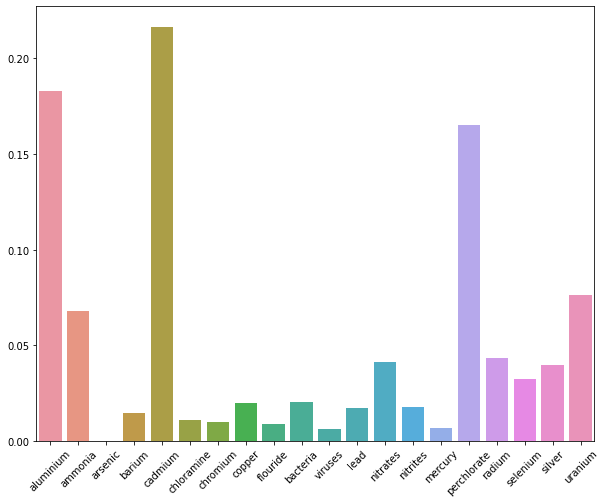

In [35]:
feat_impt=pd.DataFrame(data=tree.feature_importances_).T
feat_impt.columns=data.columns.values

names = list(data.columns.values)

feature_importances=pd.DataFrame()
for column in names:
    value=feat_impt.filter(regex=column)
    value=value.mean(axis=1)
    feature_importances[column]=value

#feature_importances=pd.melt(feature_importances)
plt.figure(figsize=(10,8))
p=sns.barplot(data=feature_importances)
p.set_xticklabels(p.get_xticklabels(),rotation=45)
feature_importances

**The tree seems to cling to some features like `['cadmium', 'arsenic', 'aluminium']` quite strongly. Earlier, he noticed that there is a near-zero relationship between the target column and the columns mentioned above. And these features can create a lot of noise that will outpace our models, so let me remove them from our dataset.**

In [39]:
data=data.drop(columns=['cadmium', 'arsenic', 'aluminium'])

## Part 2: Data Transformation Pipeline

**In order to simplify converting data between several models, and to make sure everything is consistent, I chose to use sklearn pipelines to transform the data before it was thrown into an estimator.**

## 2.1: Creating a Holdout Set

**I will create a comment group that I will use to eventually evaluate the model. Either this prevents data from leaking into our models.**

In [43]:
#split data into train and test
#we will train our model with data/target evalulate our model at the very end with eval_data/eval_taret

from sklearn.model_selection import train_test_split
data, eval_data, target, eval_target = train_test_split(data,target,test_size=.20)

## 2.2: Creating the Transformation Pipeline

**The first step in our estimated pipelines will be the transformer pipeline. The transformer will complete the following transformations:**

* Numerical Data:
    1.  Imputation transformer to fill in missing values should they exist
    2.  Standard Scaler to normalize our numerical data

**But I actually got rid of the lost data in the beginning.**

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class StringIndexer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.apply(lambda s: s.cat.codes.replace(
            {-1: len(s.cat.categories)}
        ))

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        # Part 1
        ('boolean', Pipeline([
            ('selector', TypeSelector('bool')),
        ])),  # booleans close
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('imputer',SimpleImputer()),
            ('scaler', StandardScaler()),
            
        ])),  # numericals close
        
        # Part 2
        ('categoricals', Pipeline([
            ('selector', TypeSelector('category')),
            ('labeler', StringIndexer()),
            ('encoder', OneHotEncoder()),
        ]))  # categoricals close
    ])),  # features close
])  # pipeline close

## Part 3: Model Creation

## 3.1: Creating Estimator Pipelines

**First, I'll create several estimators to use in our ensemble model. Next, I will create a dictionary of pipelines corresponding to each estimator, each including the transformer pipeline we just created as a first step. Each pipeline will fit our training data.**

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

estimators=[
    ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
    ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
    ('ridge',RidgeClassifier()),
    ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
    ('random_forest',RandomForestClassifier()),
    ('xgb',XGBClassifier(ojective='reg:logistic')),
    ('svc',LinearSVC()),
    ('deep_nn',MLPClassifier()),
    ('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto'))
]

pipes={}
for model in estimators:
    pipe=Pipeline(steps=[('data_prep',transformer),model])
    pipe.fit(data,target)
    pipes[pipe.steps[1][0]]=pipe

## 3.2: Initial Model Scoring

**I will test our model with raw parameters using four metrics: roc-auc, accuracy, and log_loss**

In [46]:
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss

_metrics={'f1':make_scorer(f1_score),'auc':make_scorer(roc_auc_score),
         'accuracy':'accuracy','logloss':make_scorer(log_loss)}

estimator_names=[model[0] for model in estimators]

def plot_estimators(estimators=estimator_names,n_splits=5,metrics=['f1','auc','accuracy','logloss']):
    metrics={key : _metrics[key] for key in metrics}
    scorers=[]
    labels=[]
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe=pipes[pipe_name]
            labels.append(pipe_name)
            kf=KFold(n_splits)
            model_score=cross_validate(pipe,data,target,scoring=metrics,cv=kf)
            scorers.append(model_score)
    
    score_lists={}
    for metric in metrics:
        score_lists[metric]=[score['test_'+metric] for score in scorers]
    
    for  i,(title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot=sns.boxplot(data=_list).set_xticklabels(labels, rotation=45)
        plt.title(title)

In [47]:
metrics={'f1':make_scorer(f1_score),'auc':make_scorer(roc_auc_score),
         'accuracy':'accuracy','logloss':make_scorer(log_loss)}

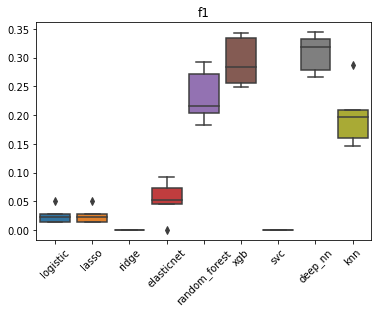

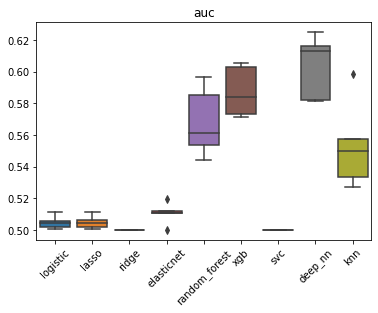

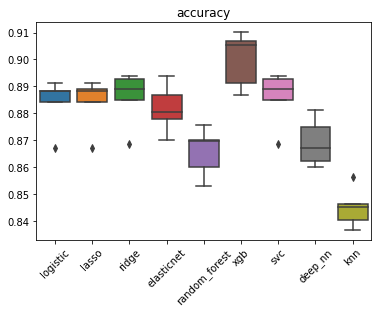

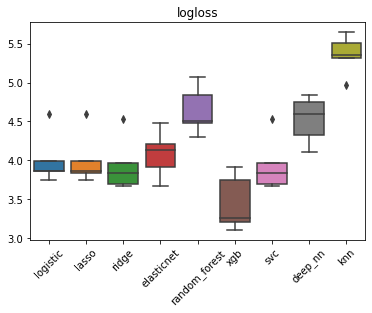

In [48]:
plot_estimators()

# Part 4: Ensemble

# 4.1: Learning Curves
Since we have a large number of features, let's plot some learning curves to help us visualize whether the model fits the number of training examples.

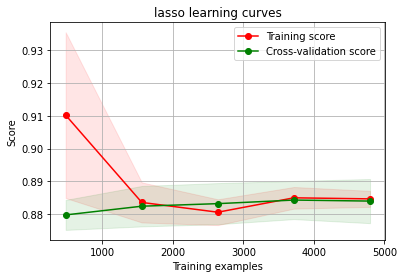

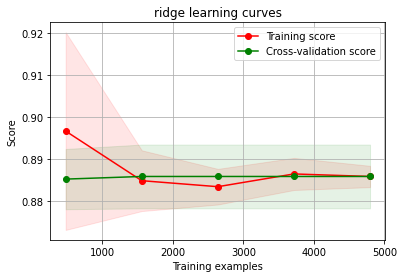

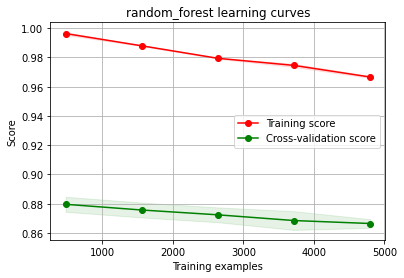

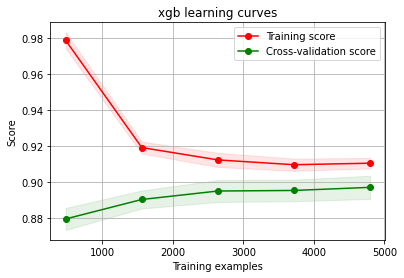

In [55]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

t=transformer
t.fit(data)
t=t.transform(data)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

to_plot=['xgb','random_forest','lasso','ridge']
for name in pipes.keys():
    if name in to_plot:
        g=plot_learning_curve(pipes[name].named_steps[name],name+' learning curves',t,target,cv=KFold(4),n_jobs=4)

# 4.2: Ensemble Creation and Final Testing

**Let's make a voting ensemble including all of our estimators and compare it to the performance of each individual estimator**

In [58]:
def print_predictions(target,predictions):
    print('auc: '+str(roc_auc_score(target,predictions)))
    print('f1: '+str(f1_score(target,predictions)))
    print('accuracy: '+str(accuracy_score(target,predictions)))
    print('logloss: '+str(log_loss(target,predictions)))

In [59]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in pipes.values()] 
vote=Pipeline(steps=[('data_prep',transformer),('voter',VotingClassifier(estimators))])
vote.fit(data,target)
predictions=vote.predict(eval_data)

print_predictions(eval_target,predictions)

auc: 0.5051418961856197
f1: 0.021621621621621623
accuracy: 0.886875
logloss: 3.9071995794226653


In [60]:
for name in pipes.keys():
    print(name)
    predictions=pipes[name].predict(eval_data)
    print_predictions(eval_target,predictions)
    print()

logistic
auc: 0.5071839303151009
f1: 0.031914893617021274
accuracy: 0.88625
logloss: 3.928787314166273

lasso
auc: 0.5071839303151009
f1: 0.031914893617021274
accuracy: 0.88625
logloss: 3.928787314166273

ridge
auc: 0.5
f1: 0.0
accuracy: 0.88625
logloss: 3.928785814921091

elasticnet
auc: 0.504789286876734
f1: 0.021505376344086023
accuracy: 0.88625
logloss: 3.9287868144178786

random_forest
auc: 0.6009857561338521
f1: 0.30666666666666664
accuracy: 0.87
logloss: 4.490076913222748

xgb
auc: 0.6242579705203118
f1: 0.39316239316239315
accuracy: 0.91125
logloss: 3.0653194035386866

svc
auc: 0.5
f1: 0.0
accuracy: 0.88625
logloss: 3.928785814921091

deep_nn
auc: 0.6350842387513755
f1: 0.37999999999999995
accuracy: 0.88375
logloss: 4.015163240560394

knn
auc: 0.5859707992994312
f1: 0.27076923076923076
accuracy: 0.851875
logloss: 5.116105728587138



**We note that there are many very bad results.**

**For the sake of computation time, I'll limit our final estimates to random forest, xgb, deep_nn, and elastic_net.**

In [61]:
from itertools import combinations

final_estimators=['random_forest','xgb','deep_nn','elasticnet']

combos=[]
for L in range(2, len(final_estimators)+1):
    for subset in combinations(final_estimators, L):
        combos.append(list(subset))


combo_names=[]
auc=[]
f1=[]
logloss=[]
accuracy=[]

for combo in combos:
    estimators=[(name,clone(pipes[name].named_steps[name])) for name in combo] 
    vote=Pipeline(steps=[('data_prep',transformer),('voter',VotingClassifier(estimators))])
    vote.fit(data,target)
    predictions=vote.predict(eval_data)

    auc.append(roc_auc_score(eval_target,predictions))
    accuracy.append(accuracy_score(eval_target,predictions))
    logloss.append(log_loss(eval_target,predictions))
    f1.append(f1_score(eval_target,predictions))
    combo_names.append(str(list(combo)))
    
score=pd.DataFrame()
score['combo']=combo_names
score['auc']=auc
score['f1']=f1
score['accuracy']=accuracy

score

,combo,auc,f1,accuracy
0,"['random_forest', 'xgb']",0.605732,0.346667,0.908125
1,"['random_forest', 'deep_nn']",0.601780,0.326531,0.896875
2,"['random_forest', 'elasticnet']",0.507184,0.031915,0.886250
3,"['xgb', 'deep_nn']",0.594743,0.316742,0.905625
4,"['xgb', 'elasticnet']",0.516484,0.063830,0.890000
5,"['deep_nn', 'elasticnet']",0.504789,0.021505,0.886250
6,"['random_forest', 'xgb', 'deep_nn']",0.604101,0.328125,0.892500
7,"['random_forest', 'xgb', 'elasticnet']",0.607422,0.349345,0.906875
8,"['random_forest', 'deep_nn', 'elasticnet']",0.597270,0.313253,0.893125
9,"['xgb', 'deep_nn', 'elasticnet']",0.602280,0.336283,0.906250


**That's the end, don't worry I'll be back to improve the results again later.**